In [36]:
import matplotlib.pyplot as plt
import os, sys
#sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
import pandas as pd
import torch
import gpytorch
from tqdm import tqdm
from AOE.gp_bandit import ExactGPModel
import seaborn as sns
import numpy as np
from AOE.gp_utils import Wasserstein_GP_mean
dtype = torch.float
class GpGenerator:
    def __init__(self, noise=1e-2):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood.noise = noise
        likelihood.noise_covar.raw_noise.requires_grad_(False)
        self.model = ExactGPModel(train_x = torch.zeros((0, 1), dtype=dtype), train_y = torch.zeros(0, dtype=dtype), likelihood = likelihood)
        
    def sample_posterior(self, x):
        self.model.eval()
        with torch.no_grad():
            y = self.model(x).rsample()
        self.model.add_point(x, y)
        return y
    
    def posterior_samples(self, n_wass=200, lv=-1 , uv=1):
        model, likelihood = self.model, self.model.likelihood
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            test_x = torch.linspace(lv, uv, n_wass, dtype=dtype)
            observed_pred = likelihood(model(test_x))
            posterior_mean_1  = observed_pred.mean
            posterior_covar_1 = observed_pred.covariance_matrix
        return posterior_mean_1, posterior_covar_1
    
    def sample_prior(self, x):
        self.model.eval()
        with torch.no_grad():
            y = self.model(x).rsample()
        return y
    
def normalize_regret(x):
    return (torch.tanh(x) + 1)/2

def generate_x():
    x_new = 2*torch.rand(1) - 1
    return x_new, pd.Series(data={'feature': x_new}, index=['feature'])

def generate_x(n):
    x_new = 2*torch.rand(n, dtype=dtype) - 1
    return x_new
    

In [33]:
# Variable Parameters

## Parameters Bandits
seed          = 0
torch.manual_seed(seed)

#Parameters Monte Carlo
L = 20
T = 50
size_window = 20
N_wasserstein_compute = 200

In [34]:
result = []
for l in range(L):
    g = GpGenerator()
    for t in tqdm(range(T)):
        dataset = generate_x(size_window)
        y = g.sample_prior(dataset)
        dataset_1 = dataset[(size_window//2):]
        y_1 = y[(size_window//2):]
        dataset_2 = dataset[:(-size_window//2)]
        y_2 = y[:(-size_window//2)]

        g.model.set_train_data(dataset_1, y_1, strict=False)
        posterior_mean_1, posterior_covar_1 = g.posterior_samples(n_wass=N_wasserstein_compute)
        g.model.set_train_data(dataset_2, y_2, strict=False)
        posterior_mean_2, posterior_covar_2 = g.posterior_samples(n_wass=N_wasserstein_compute)
        
        d = Wasserstein_GP_mean(posterior_mean_1.numpy(), posterior_covar_1.numpy(), posterior_mean_2.numpy(), posterior_covar_2.numpy())
        result.append(d)

100%|██████████| 50/50 [00:03<00:00, 15.24it/s]


In [38]:
result = np.array(result)

/home/pierre/miniconda3/envs/exec/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='Density'>

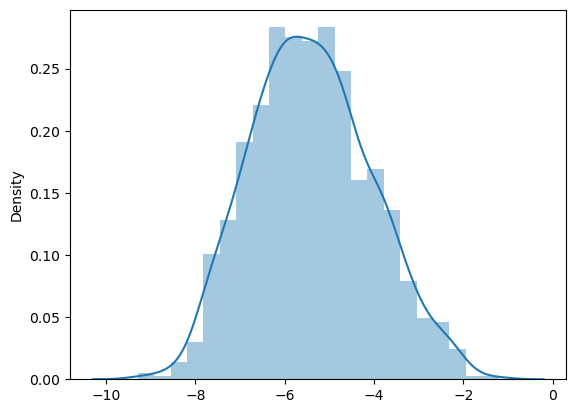

In [39]:
sns.distplot(np.log(result), hist=True, kde=True)

In [40]:
result_diff = []
for l in range(L):
    g1 = GpGenerator()
    g2 = GpGenerator()
    for t in tqdm(range(T)):
        dataset = generate_x(size_window)
        dataset_1 = dataset[(size_window//2):]
        dataset_2 = dataset[:(-size_window//2)]

        y = g.sample_prior(dataset)
        y_1 = g1.sample_prior(dataset_1)
        y_2 = g2.sample_prior(dataset_2)

        g1.model.set_train_data(dataset_1, y_1, strict=False)
        posterior_mean_1, posterior_covar_1 = g1.posterior_samples(n_wass=N_wasserstein_compute)
        g2.model.set_train_data(dataset_2, y_2, strict=False)
        posterior_mean_2, posterior_covar_2 = g2.posterior_samples(n_wass=N_wasserstein_compute)
        
        d = Wasserstein_GP_mean(posterior_mean_1.numpy(), posterior_covar_1.numpy(), posterior_mean_2.numpy(), posterior_covar_2.numpy())
        result_diff.append(d)
result_diff = np.array(result_diff)

  0%|          | 0/50 [00:00<?, ?it/s]/home/pierre/miniconda3/envs/exec/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:42: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  NumericalWarning,
100%|██████████| 50/50 [00:03<00:00, 14.13it/s]


/home/pierre/miniconda3/envs/exec/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.
/home/pierre/miniconda3/envs/exec/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  


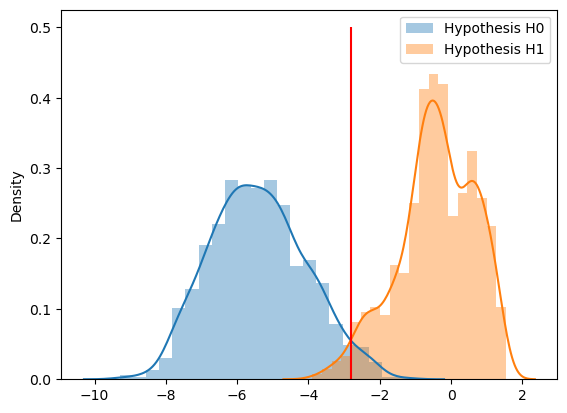

In [50]:
sns.distplot(np.log(result), hist=True, kde=True, label="Hypothesis H0")
sns.distplot(np.log(result_diff), hist=True, kde=True, label="Hypothesis H1")
plt.vlines(x = -2.8, ymin=0, ymax=0.5, colors="red")
plt.legend()

/home/pierre/miniconda3/envs/exec/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """Entry point for launching an IPython kernel.


<AxesSubplot:ylabel='Density'>

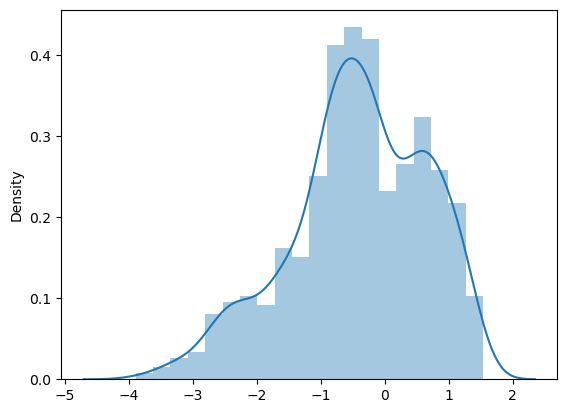